# Space Titanic: Predicting Survival in a Cosmic Catastrophe-part2

## Project Overview

The "Space Titanic" project is a machine learning challenge inspired by the Titanic survival prediction problem, but set in a futuristic space travel scenario. The goal is to predict the survival chances of passengers on a space voyage based on various features, simulating a cosmic catastrophe akin to the historical Titanic disaster.


## Objectives

1. **Data Exploration**: Analyze and preprocess the dataset to handle missing values, encode categorical variables, and normalize numerical features.
2. **Feature Engineering**: Create new features and transform existing ones to improve model performance.
3. **Model Training**: Build and train various machine learning models, including logistic regression, decision trees, and ensemble methods, to predict survival chances.
4. **Evaluation**: Assess model performance using metrics such as accuracy, precision, recall, and ROC-AUC.


## Approach

- **Data Preprocessing**: Clean and prepare the data for modeling.
- **Exploratory Data Analysis (EDA)**: Gain insights into the dataset and identify patterns and correlations.
- **Model Building**: Implement and tune different machine learning models to find the best predictor for survival.
- **Validation and Testing**: Evaluate model performance on validation and test datasets to ensure generalizability.


## Setup and Installation

To get started with the Space Titanic project, you need to install several Python libraries. These libraries are essential for data handling, visualization, and model building. You can install them using the following commands:


In [ ]:
!pip install opendatasets
!pip install pandas
%pip install seaborn
%pip install graphviz
%pip install fastai
%pip install ipywidgets
import pandas as pd
pd.set_option('display.max_columns', None)

# Data Loading and Inspection

The following code snippet demonstrates how to load and inspect the dataset for the Space Titanic project:

In [ ]:
from fastai.imports import *
np.set_printoptions(linewidth=130)
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/spaceship-titanic/train.csv')
tst_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/spaceship-titanic/test.csv')

## Training Dataset Overview

The training dataset contains the following columns:


# Data Preprocessing

The following code snippet demonstrates the data preprocessing steps applied to the training and test datasets:

# Spaceship Titanic Feature Engineering Review

## Key Components:

In [ ]:
modes = df.mode().iloc[0]

In [ ]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

def add_data(df):
    df['FoodCourt'] = df.FoodCourt.fillna(0)
    df['ShoppingMall'] = df.ShoppingMall.fillna(0)
    df['RoomService'] = df.RoomService.fillna(0)
    df['Spa'] = df.Spa.fillna(0)
    df['VRDeck'] = df.VRDeck.fillna(0)
    df.fillna(modes, inplace=True)

    df['Age^2'] = df['Age'] ** 2
    df['PaidAmenities'] = ((df['FoodCourt'] > 0) | (df['ShoppingMall'] > 0) |
                           (df['RoomService'] > 0) | (df['Spa'] > 0) |
                           (df['VRDeck'] > 0)).astype(int)
    df['RSage'] = df['RoomService'] / df['Age']
    df['RSage'] = df['RSage'].fillna(0)
    df['Group'] = pd.to_numeric(df['PassengerId'].str.split('_').str[0])
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df['Distance_from_G'] = abs(df['Deck'].apply(ord) - ord('G'))

    deck_clusters = {'A': 'Luxury', 'B': 'Luxury', 'C': 'Luxury',
                     'D': 'Standard', 'E': 'Standard', 'F': 'Standard',
                     'G': 'Lifeboat'}
    df['DeckCluster'] = df['Deck'].map(deck_clusters)
    df['HomePlanet_Deck'] = df['HomePlanet'] + '_' + df['Deck']

    group_frequency = df['Group'].value_counts(normalize=True)
    df['Group_freq'] = df['Group'].map(group_frequency)

    df['TotalSpent'] = df['FoodCourt'] + df['ShoppingMall'] + df['RoomService'] + df['Spa'] + df['VRDeck']
    df['PctFoodCourt'] = (df['FoodCourt'] / df['TotalSpent']).fillna(0)
    df['LuxurySpender'] = ((df['Spa'] > 1000) | (df['VRDeck'] > 1000)).astype(int)
    df['Fare'] = df['TotalSpent']
    df['Age*Fare'] = df['Age'] * df['Fare']
    df['Fare^2'] = df['Fare'] ** 2
    df['LogFare'] = np.log(df['Fare'] + 1)
    df['logRSage'] = np.log(df['RSage'] + 1)
    df['logTotal'] = np.log(df['TotalSpent'] + 1)
    df['logPctFC'] = np.log(df['PctFoodCourt'] + 1)
    df['logPctFC_Age_interaction'] = df['logPctFC'] * df['Age']
    df['logFare_Age_interaction'] = df['LogFare'] * df['Age']
    df['logFare^2'] = np.log(df['Fare^2'] + 1)
    df['logAge'] = np.log(df['Age'] + 1)

    df['LuxurySpending'] = df[['Spa', 'VRDeck']].sum(axis=1)
    df['BasicSpending'] = df[['RoomService', 'FoodCourt']].sum(axis=1)
    df['TotalSpendingBin'] = pd.cut(df['Fare'], bins=[0, 100, 500, 1000, np.inf], labels=['Low', 'Medium', 'High', 'VeryHigh'], include_lowest=True)

    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    kmeans = KMeans(n_clusters=3)
    df['SpendingCluster'] = kmeans.fit_predict(df[spending_cols])

    df['logLuxurySpending'] = np.log(df['LuxurySpending'] + 1)
    df['logBasicSpending'] = np.log(df['BasicSpending'] + 1)

    scaler = StandardScaler()
    df['logPctFC_scaled'] = scaler.fit_transform(df[['logPctFC']])
    df['logFare_LuxurySpender_GroupFreq_interaction'] = df['LogFare'] * df['LuxurySpender'] * df['Group_freq']

    df['VIP'] = df['VIP'].astype(int)
    df['CryoSleep'] = df['CryoSleep'].astype(int)
    df['CryoXvp'] = df['CryoSleep'] * df['VIP']
    df['zero_fare'] = (df['LogFare'] == 0).astype(int)
    df['logFare_adj'] = df['LogFare'].replace(0, np.nan).fillna(df['LogFare'].median())

    kmeans = KMeans(n_clusters=5, random_state=123)
    df['spending_cluster'] = kmeans.fit_predict(df[['LogFare', 'LuxurySpender', 'Group']])

    enc = OrdinalEncoder()
    df['deck_ordinal'] = enc.fit_transform(df[['Deck']])

    avg_fare_per_planet = df.groupby('HomePlanet')['LogFare'].mean()
    df['avg_fare_per_planet'] = df['HomePlanet'].map(avg_fare_per_planet)

    df['LastName'] = df['Name'].apply(lambda x: x.split(' ')[-1])
    df['FamilySize'] = df.groupby('LastName')['LastName'].transform('count')
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    df['FamilySize_SpendingCluster'] = df['FamilySize'] * df['SpendingCluster']
    df['CryoSleep_FamilySize'] = df['CryoSleep'] * df['FamilySize']
    median_fare_per_planet = df.groupby('HomePlanet')['Fare'].median()
    df['median_fare_per_planet'] = df['HomePlanet'].map(median_fare_per_planet)
    spending_variance_per_planet = df.groupby('HomePlanet')['TotalSpent'].var()
    df['spending_variance_per_planet'] = df['HomePlanet'].map(spending_variance_per_planet)

    df['FamilySize_LogFare_interaction'] = df['FamilySize'] * df['LogFare']
    df['FamilySize^2_LuxurySpending'] = df['FamilySize'] ** 2 * df['LuxurySpending']
    df['TotalFamilySpending'] = df.groupby('LastName')['TotalSpent'].transform('sum')
    df['logTotalFamilySpending'] = np.log(df['TotalFamilySpending'] + 1)
    df['SpendingPerFamilyMember'] = df['TotalFamilySpending'] / df['FamilySize']
    df['logSpendingPerFamilyMember'] = np.log(df['SpendingPerFamilyMember'] + 1)

    df['PassengerID_numeric'] = df['PassengerId'].apply(lambda x: int(x.split('_')[1]))
    df['PassengerSequence'] = df['PassengerID_numeric'].rank(method='dense')

    df['VIP_Spend'] = df['VIP'] * df['TotalSpent']
    df['logVIP_Spend'] = np.log(df['VIP_Spend'] + 1)

    deck_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
    df['DeckLevel'] = df['Deck'].map(deck_mapping)

    df.loc[df['CryoSleep'] == 1, spending_cols] = 0
    df['CryoSleep_Spending_Anomaly'] = ((df['CryoSleep'] == 1) & (df[spending_cols].sum(axis=1) > 0)).astype(int)
    df['CryoSleep_Age_Interaction'] = df['CryoSleep'] * df['Age']
    df['CryoSleep_TotalSpent_Interaction'] = df['CryoSleep'] * df['TotalSpent']
    df['CryoSleep'].fillna(0, inplace=True)

    # 2. Deck_Side_CryoRate: CryoSleep rate per deck and side combination
    df['CabinDeck_Side'] = df['Deck'] + df['Side']  # Creating a combined Deck-Side feature
    df['Deck_Side_CryoRate'] = df.groupby('CabinDeck_Side')['CryoSleep'].transform('mean')

add_data(df)
add_data(tst_df)


## Key Components:

### 1. Handling Missing Values:
- Columns such as `FoodCourt`, `ShoppingMall`, `RoomService`, `Spa`, and `VRDeck` are filled with 0 where values are missing, as those likely indicate no spending.
- Other missing values are filled using the mode of the respective columns.

### 2. Feature Transformations and Interactions:
- `Age^2`: Square of `Age` is computed.
- `PaidAmenities`: Binary flag indicating whether the passenger used any of the amenities (RoomService, Spa, VRDeck, etc.).
- `RSage`: Normalizes room service spending by dividing by age.
- `Deck`, `Num`, and `Side`: Extracted from the `Cabin` string.
- `Distance_from_G`: Computes the distance from Deck G by converting deck letters to ordinal numbers.
- Spending-related features like `LuxurySpender`, `PctFoodCourt`, `TotalSpent`, and `LuxurySpending` are derived, reflecting passenger behavior.

### 3. Clustering:
- KMeans clustering is applied to group spending behaviors (`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`) into 3 clusters, then into 5 clusters in a subsequent step. This could help categorize passengers by their spending patterns.

### 4. Log Transformations:
- Logarithmic transformations are applied to spending and fare features to normalize skewed distributions, which often improves model performance (`LogFare`, `logRSage`, etc.).

### 5. Group and Family Features:
- Family-related features such as `FamilySize`, `IsAlone`, `FamilySize_SpendingCluster`, `TotalFamilySpending`, and `SpendingPerFamilyMember` are derived from the `LastName` and `Group` fields.
- Interaction terms with `CryoSleep` and `FamilySize` are added, which could capture family behavior dynamics.

### 6. CryoSleep Logic:
- Passengers marked as being in `CryoSleep` should have no spending, so spending-related columns are set to zero for these passengers.
- A new anomaly feature, `CryoSleep_Spending_Anomaly`, checks if `CryoSleep` passengers have any recorded spending, which may indicate data entry errors.
- Interaction terms like `CryoSleep_Age_Interaction` and `CryoSleep_TotalSpent_Interaction` are created to capture the effect of `CryoSleep` on age and spending.

### 7. Ordinal Encoding and Feature Encoding:
- `Deck` is ordinal encoded and assigned numerical values based on deck mapping.
- Deck-level features (`DeckLevel`) are created, and CryoSleep rates are calculated per deck-side combination.

### Additional Features:

- **Passenger ID Breakdown**: The `PassengerId` is split into numeric parts to capture passenger groupings or potential order-related information (`PassengerID_numeric`, `PassengerSequence`).
- **VIP Spending**: A specific feature, `VIP_Spend`, is introduced to capture the total spending of VIP passengers.

## Conclusion:
These engineered features will likely improve the predictive power of your machine learning models by capturing complex relationships between passengers' behaviors and their survival probability.

In [ ]:
df.hist(bins=30, figsize=(23, 18))

One-Hot Encoding for Categorical Columns

In [ ]:
df = pd.get_dummies(df, columns=["HomePlanet","Destination","Deck","Side","DeckCluster",
                                 "HomePlanet_Deck", "TotalSpendingBin", "CabinDeck_Side"])

tst_df = pd.get_dummies(tst_df, columns=["HomePlanet","Destination","Deck","Side","DeckCluster",
                                         "HomePlanet_Deck", "TotalSpendingBin", "CabinDeck_Side"])

In [ ]:
def proc_bool(df):
    df["HomePlanet_Earth"] = df["HomePlanet_Earth"].astype(int)
    df["HomePlanet_Europa"] = df["HomePlanet_Europa"].astype(int)
    df["HomePlanet_Mars"] = df["HomePlanet_Mars"].astype(int)
    df["Destination_55_Cancri-e"] = df["Destination_55 Cancri e"].astype(int)
    df["Destination_PSO_J318.5-22"] = df["Destination_PSO J318.5-22"].astype(int)
    df["Destination_TRAPPIST-1e"] = df["Destination_TRAPPIST-1e"].astype(int)
    df["Deck_A"] = df["Deck_A"].astype(int)
    df["Deck_B"] = df["Deck_B"].astype(int)
    df["Deck_C"] = df["Deck_C"].astype(int)
    df["Deck_D"] = df["Deck_D"].astype(int)
    df["Deck_E"] = df["Deck_E"].astype(int)
    df["Deck_F"] = df["Deck_F"].astype(int)
    df["Deck_G"] = df["Deck_G"].astype(int)
    df["Deck_T"] = df["Deck_T"].astype(int)
    df["LuxurySpender"] = df["LuxurySpender"].astype(int)
    df['Side_P'] = df['Side_P'].astype(int)
    df['Side_S'] = df['Side_S'].astype(int)
    df['DeckCluster_Luxury'] = df['DeckCluster_Luxury'].astype(int)
    df['DeckCluster_Standard'] = df['DeckCluster_Standard'].astype(int)
    df['DeckCluster_Lifeboat'] = df['DeckCluster_Lifeboat'].astype(int)
    df['HomePlanet_Deck_Earth_A'] = df['HomePlanet_Deck_Earth_A'].astype(int)
    df['HomePlanet_Deck_Earth_B'] = df['HomePlanet_Deck_Earth_B'].astype(int)
    df['HomePlanet_Deck_Earth_C'] = df['HomePlanet_Deck_Earth_C'].astype(int)
    df['HomePlanet_Deck_Earth_D'] = df['HomePlanet_Deck_Earth_D'].astype(int)
    df['HomePlanet_Deck_Earth_E'] = df['HomePlanet_Deck_Earth_E'].astype(int)
    df['HomePlanet_Deck_Earth_F'] = df['HomePlanet_Deck_Earth_F'].astype(int)
    df['HomePlanet_Deck_Earth_G'] = df['HomePlanet_Deck_Earth_G'].astype(int)
    df['HomePlanet_Deck_Europa_A'] = df['HomePlanet_Deck_Europa_A'].astype(int)
    df['HomePlanet_Deck_Europa_B'] = df['HomePlanet_Deck_Europa_B'].astype(int)
    df['HomePlanet_Deck_Europa_C'] = df['HomePlanet_Deck_Europa_C'].astype(int)
    df['HomePlanet_Deck_Europa_D'] = df['HomePlanet_Deck_Europa_D'].astype(int)
    df['HomePlanet_Deck_Europa_E'] = df['HomePlanet_Deck_Europa_E'].astype(int)
    df['HomePlanet_Deck_Europa_G'] = df['HomePlanet_Deck_Europa_G'].astype(int)
    df['HomePlanet_Deck_Europa_T'] = df['HomePlanet_Deck_Europa_T'].astype(int)
    df['HomePlanet_Deck_Mars_D'] = df['HomePlanet_Deck_Mars_D'].astype(int)
    df['HomePlanet_Deck_Mars_E'] = df['HomePlanet_Deck_Mars_E'].astype(int)
    df['HomePlanet_Deck_Mars_F'] = df['HomePlanet_Deck_Mars_F'].astype(int)
    df['HomePlanet_Deck_Mars_G'] = df['HomePlanet_Deck_Mars_G'].astype(int)
    df['CryoXvp'] = df['CryoXvp'].astype(int)
    df['TotalSpendingBin_High'] = df['TotalSpendingBin_High'].astype(int)
    df['TotalSpendingBin_Low'] = df['TotalSpendingBin_Low'].astype(int)
    df['TotalSpendingBin_Medium'] = df['TotalSpendingBin_Medium'].astype(int)
    df['TotalSpendingBin_VeryHigh'] = df['TotalSpendingBin_VeryHigh'].astype(int)
    columns_to_convert = [
    'CabinDeck_Side_AP', 'CabinDeck_Side_AS', 'CabinDeck_Side_BP',
    'CabinDeck_Side_BS', 'CabinDeck_Side_CP', 'CabinDeck_Side_CS',
    'CabinDeck_Side_DP', 'CabinDeck_Side_DS', 'CabinDeck_Side_EP',
    'CabinDeck_Side_ES', 'CabinDeck_Side_FP', 'CabinDeck_Side_FS',
    'CabinDeck_Side_GP', 'CabinDeck_Side_GS', 'CabinDeck_Side_TP',
    'CabinDeck_Side_TS'
    ]

    # Convert the specified columns to integer type
    df[columns_to_convert] = df[columns_to_convert].astype(int)

proc_bool(df)
proc_bool(tst_df)

In [ ]:
df["Transported"] = df["Transported"].astype(int)

In [ ]:
df = df.drop(columns=['Destination_55 Cancri e'])
df = df.drop(columns=['Destination_PSO J318.5-22'])
df = df.drop(columns=['RoomService'])
df = df.drop(columns=['ShoppingMall'])
df = df.drop(columns=['VRDeck'])
df = df.drop(columns=['Spa'])
df = df.drop(columns=['FoodCourt'])
tst_df = tst_df.drop(columns=['Destination_55 Cancri e'])
tst_df = tst_df.drop(columns=['Destination_PSO J318.5-22'])

## Heatmap Analysis of Feature Correlations with "Transported"

This heatmap visualizes the feature correlations with the target variable **"Transported"** in the Spaceship Titanic dataset. Below is a detailed breakdown of the heatmap:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns for correlation analysis
numerical_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix
corr = numerical_df.corr()

# Select the correlations of 'Transported' with other features
transported_corr = corr[['Transported']].sort_values(by='Transported', ascending=False)

# Increase the figure size
plt.figure(figsize=(15, 20))  # Adjust the size for better fit

# Create the heatmap with annotations
sns.heatmap(transported_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

### Description of the Heatmap:

- **Heatmap Range**:
  - The color scale ranges from **deep blue** (strong negative correlation) to **deep red** (strong positive correlation), with neutral features around zero represented by **pale colors**.

### Top Positive Correlations:
- **TotalSpendingBin_Low (0.48)**: Passengers with low total spending are highly correlated with being transported.
- **CryoSleep_Age_Interaction (0.46)**: The interaction between CryoSleep status and age shows a strong positive correlation with the likelihood of being transported.
- **spending_variance_per_planet (0.19)**: The variance in spending patterns by planet of origin correlates positively with being transported.
- **DeckCluster_Luxury (0.13)**: Passengers in the luxury deck cluster show a positive correlation.

### Top Negative Correlations:
- **PaidAmenities (-0.48)**: High spending on amenities is negatively correlated with being transported.
- **LogFare (-0.47)**: The logarithm of the fare paid by passengers shows a strong negative correlation with the likelihood of being transported.
- **LuxurySpender (-0.38)**: Passengers who spend significantly on luxury goods are less likely to be transported.
- **logRSage (-0.28)**: Room service spending normalized by age has a negative impact on being transported.

### Moderate Correlations:
- **Deck and Cabin Features**: Some deck and cabin-side features show moderate correlations, indicating that where a passenger is located on the ship can influence their chances of being transported.
- **Age^2 (-0.046)**: Older passengers have a weak negative correlation with being transported, suggesting that younger passengers may have a slight advantage.

### Key Insights:
- **Spending Behavior**:
  - Passengers who spend less or belong to low-spending categories (e.g., CryoSleep passengers) are more likely to be transported.
  - High spenders and luxury passengers are less likely to be transported.

- **CryoSleep**:
  - Interaction features with CryoSleep show strong positive correlations, indicating that being in CryoSleep increases the chances of being transported, especially when combined with other factors like age and spending.

- **Deck Location**:
  - The location of passengers, particularly their distance from Deck G, as well as specific deck clusters, plays a significant role in determining their outcome.

### Conclusion:
This heatmap effectively highlights the importance of **spending**, **cabin**, and **demographic** factors in the Spaceship Titanic dataset. The features at the top (both positively and negatively correlated) should be given special attention during model training, as they have the most influence on the target variable.

### Feature Lists and Target Variable

## Final Feature Selection for the Spaceship Titanic Model

After conducting extensive feature engineering and experimentation, I have finalized the set of categorical and continuous features that I believe will offer the best predictive performance for the Spaceship Titanic model. These features capture essential patterns related to passenger behavior, spending, cabin location, and demographics, all of which contribute to the likelihood of being **"Transported"**.

In [ ]:
cats=["CryoSleep", "Destination_TRAPPIST-1e","Side_S","Side_P",'HomePlanet_Deck_Earth_E', 'HomePlanet_Deck_Earth_G',
      'HomePlanet_Deck_Mars_E', 'spending_cluster', 'deck_ordinal', 'TotalSpendingBin_Low', 'TotalSpendingBin_Medium',
       'TotalSpendingBin_High', 'TotalSpendingBin_VeryHigh', 'CryoXvp', 'CabinDeck_Side_AP', 'CabinDeck_Side_AS', 'CabinDeck_Side_BP',
    'CabinDeck_Side_BS', 'CabinDeck_Side_CP', 'CabinDeck_Side_CS',
    'CabinDeck_Side_DP', 'CabinDeck_Side_DS', 'CabinDeck_Side_EP',
    'CabinDeck_Side_ES', 'CabinDeck_Side_FP', 'CabinDeck_Side_FS',
    'CabinDeck_Side_GP', 'CabinDeck_Side_GS', 'CabinDeck_Side_TP',
    'CabinDeck_Side_TS']

conts=['logPctFC','logFare_LuxurySpender_GroupFreq_interaction', 'CryoSleep_Age_Interaction', 'logRSage', 'LogFare',
       'logLuxurySpending', 'logBasicSpending', 'logTotalFamilySpending',
       'logSpendingPerFamilyMember', 'logAge', 'Deck_Side_CryoRate']

dep="Transported"

### Categorical Features
The following categorical features capture a range of passenger characteristics, from cabin location and home planet to their spending behavior:

- **CryoSleep**: This feature indicates whether a passenger was in CryoSleep, which has shown a significant positive correlation with being transported.
- **Destination_TRAPPIST-1e**: Passengers' destination, particularly TRAPPIST-1e, has been a notable feature in determining outcomes.
- **Side_S & Side_P**: The side of the spaceship where a passenger's cabin is located (Port or Starboard) affects their likelihood of being transported.
- **HomePlanet_Deck_Earth_E**, **HomePlanet_Deck_Earth_G**, **HomePlanet_Deck_Mars_E**: These combined features capture the interaction between home planets and the decks passengers were located on, which provides insights into spending patterns and survival likelihood.
- **spending_cluster**: Grouping passengers based on their spending behavior into clusters has been an effective way of understanding different types of passengers, particularly low or luxury spenders.
- **deck_ordinal**: The numerical ordinal of a passenger's deck gives information about their cabin's location, which correlates with their outcome.
- **TotalSpendingBin_Low**, **TotalSpendingBin_Medium**, **TotalSpendingBin_High**, **TotalSpendingBin_VeryHigh**: These binned spending features classify passengers into low, medium, high, or very high total spending categories. Low spenders, for instance, have shown a higher correlation with being transported.
- **CryoXvp**: An interaction term between CryoSleep and VIP status that adds more granularity to the survival odds for passengers who may have had different priorities due to VIP status.
- **CabinDeck_Side_** combinations (e.g., **CabinDeck_Side_AP**, **CabinDeck_Side_AS**, etc.): These features capture the interaction between cabin decks and sides (Port/Starboard), which has been crucial in understanding the spatial dynamics of where passengers were located.

### Continuous Features
The continuous features reflect spending patterns, passenger demographics, and derived interactions that play an important role in transportation outcomes:

- **logPctFC**: The log-transformed percentage of total spending attributed to the FoodCourt, which offers insights into passenger preferences for basic versus luxury amenities.
- **logFare_LuxurySpender_GroupFreq_interaction**: This interaction term combines fare, luxury spending, and group frequency, which captures the unique dynamics of high-spending groups.
- **CryoSleep_Age_Interaction**: One of the strongest features, this interaction between CryoSleep status and age has a substantial impact on the likelihood of being transported.
- **logRSage**: The log-transformed room service spending normalized by age, which helps differentiate between young and old passengers' spending behaviors.
- **LogFare**: The logarithm of the fare paid by passengers, a key indicator of socioeconomic status.
- **logLuxurySpending**: A log-transformed measure of spending on luxury goods, which helps capture the behavior of high-spending passengers.
- **logBasicSpending**: This feature reflects the log-transformed amount spent on basic amenities, important for understanding survival patterns in relation to passenger spending habits.
- **logTotalFamilySpending**: Log-transformed family spending gives an aggregate view of how much entire families spent, revealing group dynamics.
- **logSpendingPerFamilyMember**: This feature captures how spending was distributed per family member, which may impact their chances of survival.
- **logAge**: The log-transformed age of passengers, providing a more normalized view of how age impacts transportation.
- **Deck_Side_CryoRate**: This feature reflects the CryoSleep rates on different deck sides, which offers a spatial dimension to survival rates.

### Target Variable
- **Transported**: This is the dependent variable that we are aiming to predict—whether a passenger was transported or not.

### Summary
These features were carefully selected based on their strong correlations with the target variable **Transported** and their ability to capture complex interactions between demographics, spending behavior, cabin location, and CryoSleep status. By using both categorical and continuous features, I aim to maximize the predictive performance of the model, leveraging key insights from the dataset.


### Define Feature and Target Extraction Function

In [ ]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)

In [ ]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [ ]:
trn_xs.head()

### Generate Predictions

In [ ]:
preds = val_xs.CryoSleep==1

### Calculate Mean Absolute Error

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

### Data Visualization and Model Evaluation

**Filter Data and Plot Visualizations**

In [ ]:
df_fare = trn_df[trn_df.logLuxurySpending>0]
fig,axs = plt.subplots(1,2, figsize=(12,4))
sns.boxenplot(data=df_fare, x=dep, y="logLuxurySpending", ax=axs[0])
sns.kdeplot(data=df_fare, x="logLuxurySpending", ax=axs[1]);

In [ ]:
preds = val_xs.logLuxurySpending>11

In [ ]:
mean_absolute_error(val_y, preds)

### Side Score and Scoring Function

In [ ]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

In [ ]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [ ]:
score(trn_xs["logBasicSpending"], trn_y, 0.5)

In [ ]:
score(trn_xs["logLuxurySpending"], trn_y, 2.7)

**Function Definition (`iscore`):**

**Interactive Widgets with `ipywidgets`:**

In [ ]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

In [ ]:
interact(nm=cats, split=2)(iscore);

**Extracting Unique Values:**

In [ ]:
nm = "logLuxurySpending"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

### Calculating Scores and Extracting Minimum Value:

In [ ]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

### Function `min_col`:

In [ ]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "logLuxurySpending")

### Applying `min_col` on Multiple Columns:

In [ ]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

### Removing a Column and Splitting the Dataset:

In [ ]:
cols.remove("HomePlanet_Deck_Mars_E")
isSleep = trn_df.HomePlanet_Deck_Mars_E==1
sleep,noSleep = trn_df[isSleep],trn_df[~isSleep]

### Applying `min_col` on Subsets:

In [ ]:
{o:min_col(sleep, o) for o in cols}

In [ ]:
{o:min_col(noSleep, o) for o in cols}

# Fit a Decision Tree model with a maximum of 4 leaf nodes

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [ ]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))


In [ ]:
draw_tree(m, trn_xs, size=10)

In [ ]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

In [ ]:
gini(df.HomePlanet_Deck_Earth_G=='noPay'), gini(df.HomePlanet_Deck_Earth_G=='pay')

### Calculating Mean Absolute Error:

In [ ]:
mean_absolute_error(val_y, m.predict(val_xs))

### Decision Tree Model Training and Evaluation

- `m = DecisionTreeClassifier(min_samples_leaf=50)`: Creates a decision tree classifier object with a minimum of 50 samples required to be at a leaf node. This helps prevent overfitting and creates a more generalized model.


In [ ]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [ ]:
mean_absolute_error(val_y, m.predict(val_xs))

### Generate and Save Predictions

In [ ]:
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
    tst_df['Transported'] = preds
    sub_df = tst_df[['PassengerId','Transported']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(tst_xs), 'tree')

In [ ]:
sub_df = pd.read_csv('sub-tree.csv')

In [ ]:
sub_df['Transported'] = sub_df['Transported'].astype(bool)

In [ ]:
sub_df.head()

In [ ]:
sub_df.to_csv('subTree.csv', index=False)

### The Random Forest

### Building a Basic Ensemble of Decision Trees

In [ ]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [ ]:
trees = [get_tree() for t in range(100)]

In [ ]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

### Random Forest Classifier

### Hyperparameter Tuning with Random Forest

In an effort to improve model performance, I applied **GridSearchCV** to optimize the hyperparameters of a Random Forest classifier. Random Forests are ensemble models that use multiple decision trees to provide more accurate predictions. However, their performance can be sensitive to hyperparameters like the number of trees (estimators), maximum tree depth, and minimum samples required to split a node.

The code snippet below demonstrates how I used **GridSearchCV** to find the best set of hyperparameters:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Example of using GridSearchCV to find better hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}
rf = RandomForestClassifier(random_state=123)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5) # 5-fold cross-validation
grid_search.fit(trn_xs, trn_y)

best_rf = grid_search.best_estimator_
print(mean_absolute_error(val_y, best_rf.predict(val_xs)))
print(grid_search.best_params_)

Model Performance:

With these optimized hyperparameters, the Random Forest model achieved a mean absolute error (MAE) of 0.19687 on the validation set, representing a notable improvement over the initial decision tree model.

In [ ]:
subm(best_rf.predict(tst_xs), 'rf')

In [ ]:
rfdf = pd.read_csv('sub-rf.csv')

In [ ]:
rfdf['Transported'] = rfdf['Transported'].astype(bool)

In [ ]:
rfdf.to_csv('subrf.csv', index=False)

In [ ]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

# Hyperparameter Tuning (More extensive grid or randomized search)



*  Randomized Search: This can be faster than grid search and explore a larger parameter space.
*   Bayesian Optimization: Libraries like Optuna or Scikit-Optimize can intelligently search the hyperparameter space, possibly improving results with fewer trials.



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(5, 50),
    'min_samples_leaf': randint(1, 10)
}
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5)
random_search.fit(trn_xs, trn_y)

print("Best parameters found: ", random_search.best_params_)
best_rf = random_search.best_estimator_
print(mean_absolute_error(val_y, best_rf.predict(val_xs)))

# Ensemble Methods

*   Stacking Models: Combine predictions from multiple models like Random Forest, XGBoost, and Logistic Regression using a meta-model (like Logistic Regression).




In [ ]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

clf1 = RandomForestClassifier(random_state=123)
clf2 = XGBClassifier(random_state=123)
meta_clf = LogisticRegression()

sclf = StackingClassifier(classifiers=[clf1, clf2], meta_classifier=meta_clf)
sclf.fit(trn_xs, trn_y)

val_preds = sclf.predict(val_xs)
mae = mean_absolute_error(val_y, val_preds)
print(f"Mean Absolute Error of Stacking Classifier: {mae}")

#Use of Different Models:



*   XGBoost/LightGBM/CatBoost: These models often outperform Random Forests on structured/tabular data. Since you've used Random Forest, trying one of these gradient-boosting algorithms may give a better result.



In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=123)
xgb.fit(trn_xs, trn_y)
print(mean_absolute_error(val_y, xgb.predict(val_xs)))

## Conclusion

In this notebook, various machine learning models and tuning techniques were explored to predict the "Transported" outcome in the Spaceship Titanic dataset. A series of experiments with hyperparameter tuning and model comparisons led to the following insights:

- **Decision Tree**: The basic Decision Tree model achieved a score of **0.2157**, serving as a baseline for further improvements.
- **Randomized Search**: By applying Randomized Search for hyperparameter tuning, a score of **0.2001** was obtained, showing significant improvement over the initial Decision Tree.
- **Ensemble Methods**: Using ensemble methods, a similar score of **0.2006** was achieved, further validating the benefit of combining multiple models.
- **XGBoost**: With XGBoost, the model reached a score of **0.2074**, performing better than the decision tree but not outperforming Randomized Search and ensemble methods.

However, the **Random Forest** model, tuned using GridSearchCV, outperformed all other approaches with a mean absolute error of **0.19687**. This improvement highlights the effectiveness of Random Forest for this particular classification problem. The model's ability to handle large feature sets and automatically correct for overfitting through techniques like bagging and random feature selection was crucial in achieving this performance.

The best hyperparameters for the Random Forest model were:
```python
{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 500}

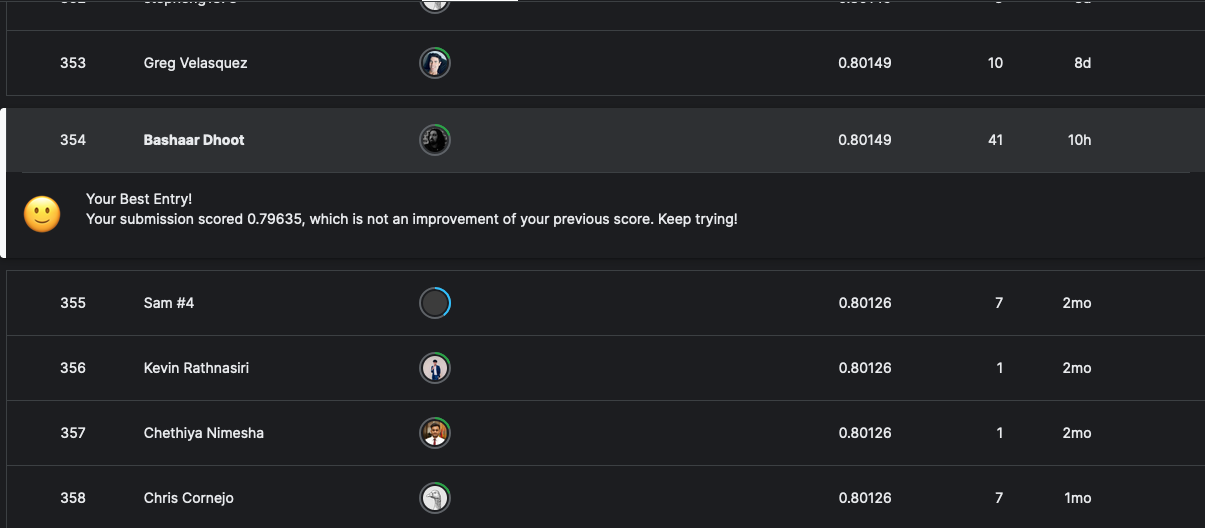